In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import bs4
from bs4 import BeautifulSoup
from datetime import datetime
from huggingface_hub import login
from transformers import LlamaTokenizer

import utils


orig_prettify = bs4.BeautifulSoup.prettify
r = re.compile(r'^(\s*)', re.MULTILINE)
def prettify(self, encoding=None, formatter="minimal", indent_width=4):
    return r.sub(r'\1' * indent_width, orig_prettify(self, encoding, formatter))
bs4.BeautifulSoup.prettify = prettify

pd.set_option('display.max_rows', 120)
pd.set_option('max_colwidth', 1000)

secrets = utils.jload('secrets.json')

In [25]:
generated_tasks = utils.jload('regen.json')
df = pd.DataFrame(generated_tasks)
print('Number of generated tasks:', len(df))

Number of generated tasks: 200


### Check `alt` Text

In [295]:
# def get_alt_texts(html):
#     alt_texts = []
#     soup = BeautifulSoup(html, 'html.parser')
#     img_tags = soup.find_all('img', alt=True)
    
#     for img_tag in img_tags:
#         alt_text = img_tag['alt'].strip()
#         if alt_text:
#             alt_texts.append(alt_text)
            
#     return alt_texts
  
# def count_avg_alt_word(alt_texts):
#   total_words = 0
#   total_strings = len(alt_texts)

#   for string in alt_texts:
#       words = string.split()
#       total_words += len(words)

#   if total_strings > 0:
#       avg_word_count = total_words / total_strings
#   else:
#       avg_word_count = 0

#   return int(avg_word_count)
  
# # Check the word counts of alt texts in HTML outputs
# df['alt_texts'] = df['output'].apply(get_alt_texts)
# df['avg_alt_word_count'] = df['alt_texts'].apply(count_avg_alt_word)

# alt_word_count_gte_5_df = df[df['avg_alt_word_count'] >= 5]
# alt_word_count_lt_5_df = df[df['avg_alt_word_count'] < 5]

# print('Number of alt texts with word count >= 5:', len(alt_word_count_gte_5_df))
# print('Number of alt texts with word count < 5:', len(alt_word_count_lt_5_df))

Number of alt texts with word count >= 5: 0
Number of alt texts with word count < 5: 200


In [267]:
# new_generated_tasks_file_name = f'regen_new_{datetime.now().strftime("%Y%m%d%H%M%S")}.json'

# # Export data with alt texts having a word count < 5 to JSON
# alt_word_count_lt_5_df[[
#   'instruction', 
#   'output', 
#   'most_similar_instructions', 
#   'avg_similarity_score'
# ]].to_json(new_generated_tasks_file_name, orient='records')
# print(f'{new_generated_tasks_file_name} exported sucessfully!')

### Check Character Distribution

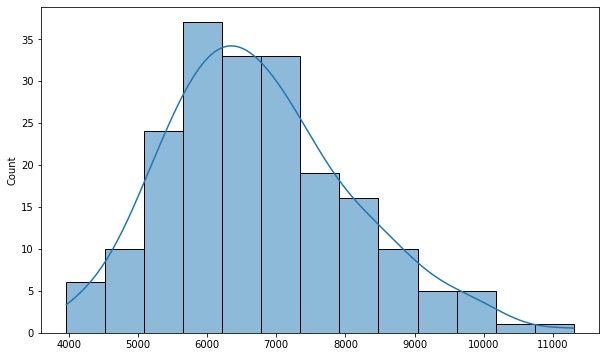

In [296]:
char_counts = df[['instruction', 'output']].applymap(len).sum(axis=1)

# Check the distribution of characters
plt.figure(figsize=(10,6))
sns.histplot(char_counts, kde=True)
plt.show()

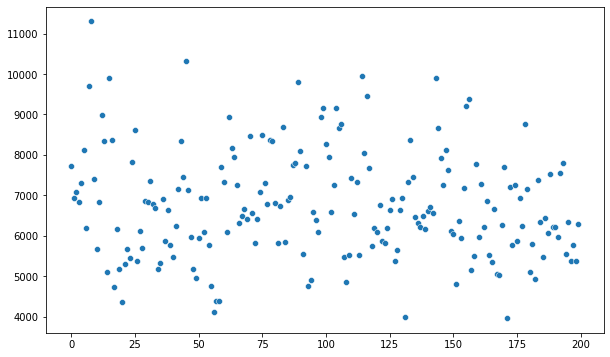

In [297]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=char_counts.index, y=char_counts.values)
plt.show()

### Check Token

In [223]:
login(token=secrets['HUGGING_FACE_TOKEN'])

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/admin/.cache/huggingface/token
Login successful


In [224]:
tokenizer = LlamaTokenizer.from_pretrained('meta-llama/Llama-2-7b-hf')

In [225]:
prompt = 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:\n{output}'
max_char_task = df.iloc[char_counts.argmax()].to_dict()
formatted_prompt = prompt.format(**max_char_task)

input_ids = tokenizer(formatted_prompt, return_tensors='pt').input_ids
print('Max. number of tokens:', len(input_ids[0])) 
print('Mean number of tokens:', int(char_counts.mean()/(char_counts.max()/len(input_ids[0]))))

Max. number of tokens: 4323
Mean number of tokens: 2214


In [243]:
def count_token(row):
  formatted_prompt = prompt.format(**row)
  input_ids = tokenizer(formatted_prompt, return_tensors='pt').input_ids
  return len(input_ids[0])

df['token_count'] = df.apply(count_token, axis=1)

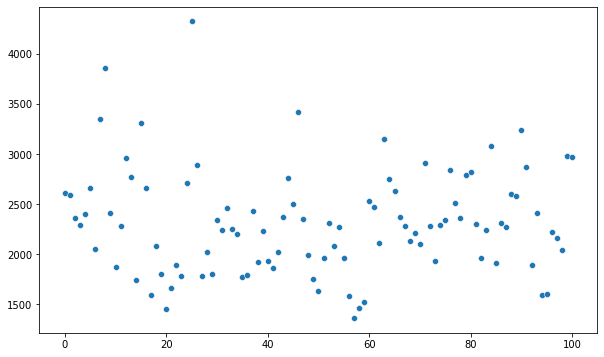

In [244]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['token_count'].index, y=df['token_count'].values)
plt.show()

In [263]:
len(df[df['token_count'] >= 3424])

3

### Clean CDN

In [26]:
def clean_cdn_tags(html):
  soup = BeautifulSoup(html, 'html.parser')
  
  # Find all link and script tags with integrity and crossorigin attributes
  link_tags = soup.find_all('link', attrs={'integrity': True, 'crossorigin': True})
  script_tags = soup.find_all('script', attrs={'integrity': True, 'crossorigin': True})

  # Remove the integrity and crossorigin attributes from the tags
  for tag in link_tags:
      del tag['integrity']
      del tag['crossorigin']
      
  for tag in script_tags:
      del tag['integrity']
      del tag['crossorigin']

  cleaned_html = str(soup.prettify(indent_width=2))
  return cleaned_html

cleaned_df = df
cleaned_df['output'] = cleaned_df['output'].apply(clean_cdn_tags)
print('Original output:\n', df['output'][0][0:500])
print()
print('Cleaned output:\n', cleaned_df['output'][0][0:500])

Original output:
 <!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="utf-8"/>
    <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
    <title>
      Online Clothing Store
    </title>
    <!-- Bootstrap 5.3 CSS -->
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.1/dist/css/bootstrap.min.css" rel="stylesheet"/>
    <!-- Bootstrap Icons 1.10 CSS -->
    <link href="https://cdn.jsdelivr.net/npm/bootstrap-icons@1.10.5/font/bootstrap-icons.css" rel="stylesheet"/>
  </head>
 

Cleaned output:
 <!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="utf-8"/>
    <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
    <title>
      Online Clothing Store
    </title>
    <!-- Bootstrap 5.3 CSS -->
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.1/dist/css/bootstrap.min.css" rel="stylesheet"/>
    <!-- Bootstrap Icons 1.10 CSS -->
    <link href="https://cdn.jsdelivr.net/npm/bootstrap-icons@1.10.5/font/bootstrap-icon

In [28]:
cleaned_df[df.columns].to_json('regen-cleaned.json', orient='records')
print('regen-cleaned.json exported sucessfully!')

regen-cleaned.json exported sucessfully!
